In [1]:
# !pip install --user -U tqdm
# !pip install --user --upgrade pip

import copy
import os
import time

import pandas as pd
import numpy as np

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
import joblib
import gc
# from tqdm import tqdm

import matplotlib.pyplot as plt


In [8]:
NUM_EPOCH = 20
device = 'cpu'


In [5]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True


def f1_score_eval(preds, labels):
    preds = preds.reshape(-1,)
    labels = labels.reshape(-1,)
    scores = f1_score(y_true=labels, y_pred=preds, labels=[0,1,2], average=None)
    scores = scores[0]*0.2+scores[1]*0.2+scores[2]*0.6
    return scores


In [4]:
def gen_lstm_feats(txt_path, mode='is_train'):
    df = pd.read_csv(txt_path, sep=';', header=None, usecols=['base', 'history_feature1', 'history_feature2', 'history_feature3', 'history_feature4'],
                     names=['base', 'recent_feature', 'history_feature1', 'history_feature2', 'history_feature3', 'history_feature4'])
    df['link'] = df['base'].apply(lambda x: x.split(' ')[0])  # 不同路段（道路属性）的周周期性不同
    if mode in ['is_train', 'is_valid']:
        df['label'] = df['base'].apply(lambda x: int(x.split(' ')[1]))
        df['label'] = df['label'].apply(lambda x: 3 if x > 3 else x)
        df['label'] -= 1
        # df['current_slice_id'] = df[0].apply(lambda x: int(x.split(' ')[2]))
        df['future_slice_id'] = df['base'].apply(lambda x: int(x.split(' ')[3]))  # 不同时间片的周周期性不同
    else:
        df['label'] = -1
        # df['current_slice_id'] = df[0].apply(lambda x: int(x.split(' ')[2]))
        df['future_slice_id'] = df['base'].apply(lambda x: int(x.split(' ')[3]))
    # df = df.astype('int')
    df.drop(['base'], axis=1, inplace=True)

    def get_split(df_t):
        arr_list = list()
        print('Spliting... total 5')
        for i in range(5):
            f = df_t[i].str.split(':', expand=True)[1].str.split(',', expand=True).astype('float').values.reshape(1, -1, 4)
            arr_list.append(f)
        return np.concatenate(arr_list, axis=2)

    history_feature1 = df.history_feature1.str.split(' ', expand=True)
    # TODO 加入future时间片和link道路属性特征，或者在输出全连接加？
    history_feature1 = get_split(history_feature1)
    df.drop(['history_feature1'], axis=1, inplace=True)

    history_feature2 = df.history_feature2.str.split(' ', expand=True)
    history_feature2 = get_split(history_feature2)
    df.drop(['history_feature2'], axis=1, inplace=True)

    history_feature3 = df.history_feature3.str.split(' ', expand=True)
    history_feature3 = get_split(history_feature3)
    df.drop(['history_feature3'], axis=1, inplace=True)

    history_feature4 = df.history_feature4.str.split(' ', expand=True)
    history_feature4 = get_split(history_feature4)
    df.drop(['history_feature4'], axis=1, inplace=True)

    combined_feature = np.concatenate([history_feature1, history_feature2, history_feature3, history_feature4], axis=0)
    print(f'combined features size (4, n, 20?): {combined_feature.shape}')
    return combined_feature, df.label


In [6]:
class Rnn(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_layer, n_classes):
        super(Rnn, self).__init__()
        self.n_layer = n_layer
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(in_dim, hidden_dim, n_layer, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)
        # 此时可以从out中获得最终输出的状态h
        # x = out[:, -1, :]
        x_feat = h_n[-1, :, :]
        x = self.classifier(x_feat)
        return x, x_feat


In [6]:
def train_model(model, criterion, optimizer, num_epochs):
    begin_time = time.time()
    best_weights = copy.deepcopy(model.state_dict())  # copy the weights from the model
    best_f1 = 0.0
    best_loss = 0.0
    best_epoch = 0

    for epoch in range(num_epochs):
        print("-*-" * 20)
        for phase in ['train', 'valid']:
            if phase == 'train':
                # schedular.step()  #pytorch后续版本将此放在optimizer.step后
                # adjust_lr(optimizer, epoch)
                model.train()
                #
                preds_epoch = torch.Tensor(train_data_size,)
                labels_epoch = torch.Tensor(train_data_size,)
            else:
                model.eval()
                #
                preds_epoch = torch.Tensor(valid_data_size,)
                labels_epoch = torch.Tensor(valid_data_size,)
            running_loss = 0.0
            running_acc = 0.0
            correct = 0
            scores = []
            

            for i, (features, labels) in enumerate(train_loader if phase == 'train' else valid_loader):
                data_x = features.to(device)
                data_y = labels.to(device).reshape(-1,)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # data_x = torch.tensor(data_x, dtype=torch.float32)
                    opt, _ = model(data_x)
                    pred = torch.max(opt, 1)[1]
                    loss = criterion(opt, data_y)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # 以下为后添加
                current_bsize = features.size(0)
                from_ = int(batch_id * (train_loader.batch_size if phase == 'train' else valid_loader.batch_size))
                to_ = int(from_ + current_bsize)
                preds_epoch[from_:to_] = pred.detach().cpu().view(-1,)
                labels_epoch[from_:to_] = labels.detach().cpu().view(-1,)

                # if phase == 'train':
                #     schedular.step()
                running_loss += loss.item() * features.size(0)
                # running_acc += torch.sum(pred == labels)
                correct_counts = pred.eq(labels.detach().view_as(pred))
                correct += correct_counts.sum().item()
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                running_acc += acc.item() * features.size(0)
                scores.append(f1_score_eval(pred.numpy(), labels.numpy()))
                print("Phase: {}  Loss: {:.4f} Accuracy: {:.4f} F1 score: {:.4f} at batch {:03d}".format(
                    phase, running_loss/(i+1), running_acc/(i+1), scores[i], i+1)) if (i+1)%50==0 else None
            if phase == 'train':
                avg_train_loss = running_loss / train_data_size
                avg_train_acc = running_acc / train_data_size
                avg_train_f1 = f1_score_eval(preds_epoch.numpy(), labels_epoch.numpy())
            elif phase == 'valid':
                avg_valid_loss = running_loss / valid_data_size
                avg_valid_acc = running_acc / valid_data_size
                valid_acc_2 = 100. * correct / valid_data_size
                avg_valid_f1 = f1_score_eval(preds_epoch.numpy(), labels_epoch.numpy())

                if avg_valid_f1 > best_f1:
                    # Upgrade the weights
                    best_f1 = avg_valid_f1
                    best_loss = avg_valid_loss
                    best_epoch = (epoch + 1)
                    best_weights = copy.deepcopy(model.state_dict())
                elif avg_valid_f1 == best_f1:
                    if avg_valid_loss < best_loss:
                        # Upgrade the weights
                        best_f1 = avg_valid_f1
                        best_loss = avg_valid_loss
                        best_epoch = (epoch + 1)
                        best_weights = copy.deepcopy(model.state_dict())
            print(f'{phase} phase report: ')
            print(classification_report(labels_epoch.numpy(), preds_epoch.numpy(), digits=4))

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc, avg_train_f1, avg_valid_f1])
        print(
            "Epoch: {:03d}, Train: Loss: {:.4f}, Accuracy: {:.4f}, F1 score: {:.4f} \n\t\tValid: Loss: {:.4f}, Accuracy: {:.4f}, acc2: {}/{} ({:.4f}, F1 score: {:.4f})".format(
                (epoch + 1), avg_train_loss, avg_train_acc, avg_train_f1, avg_valid_loss, avg_valid_acc, correct, valid_data_size, valid_acc_2, avg_valid_f1
            ))
        print("Best F1 score for validation: {:.4f}, Loss :{:.4f}, at epoch {:03d}".format(best_f1, best_loss, best_epoch))
        # if (epoch + 1) % 5 == 0:
        #     torch.save(model.state_dict(), os.path.join(image_dir, "weight_avgp_epoch" + str(epoch + 1) + '.pth'))
        # schedular.step()


    time_elapse = time.time() - begin_time
    print('Training Complete in{:.0f}m {:0f}s'.format(
        time_elapse // 60, time_elapse % 60
    ))
    print('Best Val F1: {:.4f}, Best Val Loss: {:.4f}'.format(best_f1, best_loss))

    torch.save(model.state_dict(), os.path.join(path, 'lstm', "weight_last_epoch" + str(num_epochs) + '.pth'))
    model.load_state_dict(best_weights)
    torch.save(model.state_dict(), os.path.join(path, 'lstm', "weight_best_epoch" + str(best_epoch) + '.pth'))
    #torch.save(model, os.path.join(image_dir, "model_avg_best_epoch" + str(best_epoch) + '.pth'))

    return model, history, best_epoch


In [ ]:
if __name__ == "__main__":
    path = '../'
    """
    train_path = path + 'traffic/20190701.txt'
    valid_path = path + 'traffic/20190702.txt'
    train_date = train_path.split('/')[-1][:-4]
    valid_date = valid_path.split('/')[-1][:-4]
    """
    
    train_select = {'20190701':5261, '20190702':5354, '20190703':5173, '20190704':5178, '20190705':4818, 
                   '20190706':4818, '20190707':5128, '20190708':5150, '20190709':5001, '20190710':5302, 
                   '20190711':5514, '20190712':5454, '20190713':5307, '20190714':5054, '20190715':5480, 
                   '20190716':5436, '20190717':}
    for tk, tv in train_select.items():
        train_select[tk] = tv + 5000
    
    valid_select = {'20190726':5241, '20190727':4876, '20190728':5260, '20190729':5367, '20190730':5344}

    setup_seed(2020)


In [8]:
    """
    if os.path.exists(f'{train_date}_x.pkl'):
        train_x = joblib.load(f'{train_date}_x.pkl')
        train_y = joblib.load(f'{train_date}_y.pkl')
    else:
        train_x, train_y = gen_lstm_feats(train_path)
        joblib.dump(train_x, f'{train_date}_x.pkl')
        joblib.dump(train_y, f'{train_date}_y.pkl')
    if os.path.exists(f'{valid_date}_x.pkl'):
        valid_x = joblib.load(f'{valid_date}_x.pkl')
        valid_y = joblib.load(f'{valid_date}_y.pkl')
    else:
        valid_x, valid_y = gen_lstm_feats(valid_path, mode='is_valid')
        joblib.dump(valid_x, f'{valid_date}_x.pkl')
        joblib.dump(valid_y, f'{valid_date}_y.pkl')
    """
    

In [ ]:
    txt_path = path + 'traffic/'
    
    df_train = pd.DataFrame()
    for train_day, n_row in train_select.items():
        if os.path.exists(f'{train_day}_x.pkl'):
            train_x = joblib.load(f'{train_day}_x.pkl')
            train_y = joblib.load(f'{train_day}_y.pkl')
        else:
            train_x, train_y = gen_lstm_feats(txt_path+train_day+'.txt')
            joblib.dump(train_x, f'{train_day}_x.pkl')
            joblib.dump(train_y, f'{train_day}_y.pkl')
        seq_len, data_num, feat_size = train_x.shape
        train_tmp = train_x.swapaxes(0, 1).reshape(data_num, -1)
        train_tmp = pd.DataFrame(train_tmp)
        train_tmp['id'] = range(0, train_tmp.shape[0])
        train_tmp['label'] = train_y
        train_row = pd.read_csv(f"{path}adversarial_validation/adversarial_validation_{train_day}.csv", nrows=n_row)
        train_tmp = train_tmp.merge(train_row, on='id', how='right')
        train_tmp.drop(['id', 'preds'], axis=1, inplace=True)
        df_train = pd.concat([df_train, train_tmp], axis=0, ignore_index=True)
    del train_tmp, train_row
    train_y = df_train['label']
    df_train.drop(['label'], axis=1, inplace=True)
    train_x = df_train.values.reshape(-1, seq_len, feat_size)
    train_x = train_x.swapaxes(0, 1)
    del df_train
    
    df_valid = pd.DataFrame()
    for valid_day, n_row in valid_select.items():
        if os.path.exists(f'{valid_day}_x.pkl'):
            valid_x = joblib.load(f'{valid_day}_x.pkl')
            valid_y = joblib.load(f'{valid_day}_y.pkl')
        else:
            valid_x, valid_y = gen_lstm_feats(txt_path+valid_day+'.txt')
            joblib.dump(valid_x, f'{valid_day}_x.pkl')
            joblib.dump(valid_y, f'{valid_day}_y.pkl')
        seq_len, data_num, feat_size = valid_x.shape
        valid_tmp = valid_x.swapaxes(0, 1).reshape(data_num, -1)
        valid_tmp = pd.DataFrame(valid_tmp)
        valid_tmp['id'] = range(0, valid_tmp.shape[0])
        valid_tmp['label'] = valid_y
        valid_row = pd.read_csv(f"{path}adversarial_validation/adversarial_validation_{valid_day}.csv", nrows=n_row)
        valid_tmp = valid_tmp.merge(valid_row, on='id', how='right')
        valid_tmp.drop(['id', 'preds'], axis=1, inplace=True)
        df_valid = pd.concat([df_valid, valid_tmp], axis=0, ignore_index=True)
    del valid_tmp, valid_row
    valid_y = df_valid['label']
    df_valid.drop(['label'], axis=1, inplace=True)
    valid_x = df_valid.values.reshape(-1, seq_len, feat_size)
    valid_x = valid_x.swapaxes(0, 1)
    del df_valid
    

In [9]:
    seq_len, data_num, feat_size = train_x.shape
    train_x = train_x.swapaxes(0, 1).reshape(data_num, seq_len*feat_size)
    scaler = StandardScaler()
    scaler.fit(train_x)
    joblib.dump(scaler, f'standard_scaler.pkl')
    train_x = scaler.transform(train_x)
    train_x = train_x.reshape(data_num, seq_len, feat_size)
    valid_x = valid_x.swapaxes(0, 1).reshape(-1, seq_len * feat_size)
    valid_x = scaler.transform(valid_x)
    valid_x = valid_x.reshape(-1, seq_len, feat_size)
    

In [10]:
    train_y = train_y.values.reshape(-1, 1)
    valid_y = valid_y.values.reshape(-1, 1)
    

In [11]:
    train_x = torch.from_numpy(train_x).float()
    train_y = torch.from_numpy(train_y)
    valid_x = torch.from_numpy(valid_x).float()
    valid_y = torch.from_numpy(valid_y)

    gc.collect()
    

110

In [12]:
    train_x.dtype

torch.float32

In [13]:
    data = {
        'train': TensorDataset(train_x, train_y),
        'valid': TensorDataset(valid_x, valid_y)
    }
    train_data_size = data['train'].__len__()
    valid_data_size = data['valid'].__len__()
    print('train_data_size, valid_data_size: ' + str(train_data_size) + ', ' + str(valid_data_size))

    train_loader = DataLoader(data['train'], batch_size=2048, shuffle=True, num_workers=4, pin_memory=True)
    valid_loader = DataLoader(data['valid'], batch_size=2048, shuffle=False, num_workers=4, pin_memory=True)


train_data_size, valid_data_size: 503556, 505953


In [14]:
    model_ft = Rnn(feat_size, 128, 1, 3)
    model_ft = model_ft.to(device)
    criterion_ft = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(model_ft.parameters())
    history = []
    

In [16]:
    num_params = 0
    for param in model_ft.parameters():
        num_params += param.numel()
    print(num_params)

77187


In [ ]:
    model_ft, history_ft, best_epoch_ft = train_model(model_ft, criterion_ft, optimizer_ft, num_epochs=NUM_EPOCH)


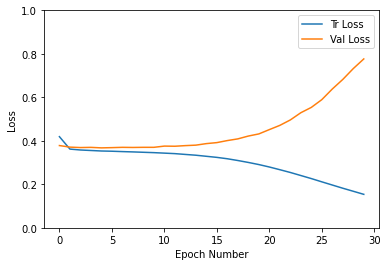

In [17]:
    history = np.array(history)
    plt.plot(history[:, 0:2])
    plt.legend(['Tr Loss', 'Val Loss'])
    plt.xlabel('Epoch Number')
    plt.ylabel('Loss')
    plt.ylim(0, 1)
    plt.savefig('lstm_loss_curve.png')
    

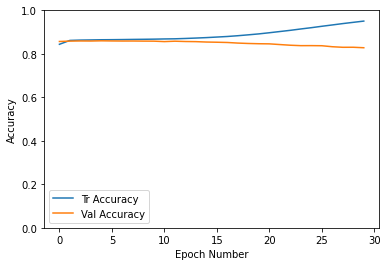

In [18]:
    plt.plot(history[:, 2:4])
    plt.legend(['Tr Accuracy', 'Val Accuracy'])
    plt.xlabel('Epoch Number')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.savefig('lstm_accuracy_curve.png')
    

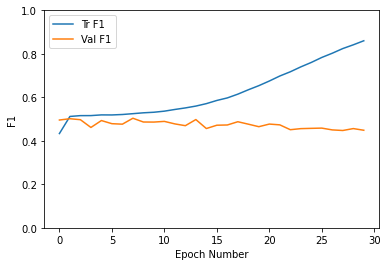

In [19]:
    plt.plot(history[:, 4:6])
    plt.legend(['Tr F1', 'Val F1'])
    plt.xlabel('Epoch Number')
    plt.ylabel('F1')
    plt.ylim(0, 1)
    plt.savefig('lstm_F1_curve.png')
    

In [20]:
    # 用于提取测试集的周特征，与下个cell执行其一
    model_ft.load_state_dict(torch.load('weight_best_epoch8.pth'))
    scaler = joblib.load('standard_scaler.pkl')
    
    if os.path.exists(f'test_x.pkl'):
        test_x = joblib.load(f'test_x.pkl')
    else:
        test_path = path + '20190801_testdata.txt'
        test_x, _ = gen_lstm_feats(test_path, mode='is_test')
        joblib.dump(test_x, f'test_x.pkl')
    

Spliting... total 5
Spliting... total 5
Spliting... total 5
Spliting... total 5
combined features size (4, n, 20?): (4, 176057, 20)


In [44]:
    # 用于提取训练集的周特征，与上个cell执行其一
    model_ft.load_state_dict(torch.load('weight_best_epoch8.pth'))
    scaler = joblib.load('standard_scaler.pkl')
    
    train_date = 20190704
    if os.path.exists(f'{train_date}_x.pkl'):
        test_x = joblib.load(f'{train_date}_x.pkl')
    else:
        train_path = path + f'traffic/{train_date}.txt'
        test_x, test_y = gen_lstm_feats(train_path, mode='is_train')
        joblib.dump(test_x, f'{train_date}_x.pkl')
        joblib.dump(test_y, f'{train_date}_y.pkl')
    

Spliting... total 5
Spliting... total 5
Spliting... total 5
Spliting... total 5
combined features size (4, n, 20?): (4, 516549, 20)


In [45]:
    test_x = test_x.swapaxes(0, 1).reshape(-1, seq_len * feat_size)
    test_x = scaler.transform(test_x)
    test_x = test_x.reshape(-1, seq_len, feat_size)
    
    test_x = torch.from_numpy(test_x).float()
    

In [46]:
    test_set = TensorDataset(test_x)
    test_data_size = test_set.__len__()
    print('test_data_size: ' + str(test_data_size))

    test_loader = DataLoader(test_set, batch_size=2048, shuffle=False, num_workers=0, pin_memory=True)
    

test_data_size: 516549


In [47]:
    model_ft = model_ft.to(device)
    model_ft.eval()
    
    hidden_feats = torch.Tensor(test_data_size, 128)
    

In [ ]:
    test_x

In [48]:
    for batch_id, features in enumerate(test_loader):
        data_x = features[0].to(device)
        current_bsize = features[0].size(0)
        from_ = int(batch_id * test_loader.batch_size)
        to_ = int(from_ + current_bsize)
        
        x = torch.autograd.Variable(data_x, requires_grad=False)
        _, hidden_out = model_ft(x)
        # output = output.squeeze(0)

        hidden_feats[from_:to_] = hidden_out.detach().cpu()
        print(f'batch {batch_id+1} completed') if (batch_id+1)%20==0 else None

    hidden_feats = hidden_feats.numpy()
    hidden_feats.shape

batch 20 completed
batch 40 completed
batch 60 completed
batch 80 completed
batch 100 completed
batch 120 completed
batch 140 completed
batch 160 completed
batch 180 completed
batch 200 completed
batch 220 completed
batch 240 completed


(516549, 128)

In [49]:
    df = pd.DataFrame(hidden_feats, columns=[f'lstm_{i}' for i in range(128)]).astype(float)

    df.to_csv(f'./csv/lstm_feats_{train_date}.csv', index=False, encoding='utf8')
    df.head(5)
    

,lstm_0,lstm_1,lstm_2,lstm_3,lstm_4,lstm_5,lstm_6,lstm_7,lstm_8,lstm_9,...,lstm_118,lstm_119,lstm_120,lstm_121,lstm_122,lstm_123,lstm_124,lstm_125,lstm_126,lstm_127
0,-0.617506,-0.010991,0.613916,-0.588238,0.641709,-0.463686,0.170780,0.295360,0.661418,-0.664157,...,0.497812,-0.350101,-0.451295,0.379104,0.459181,0.044742,0.103418,0.676691,-0.436050,0.633939
1,-0.418632,-0.024895,0.391175,-0.396902,0.629836,-0.257972,0.038932,0.159631,0.588767,-0.522501,...,0.301496,-0.285323,-0.268450,0.317287,0.431478,0.016857,0.037048,0.490244,-0.168363,0.554600
2,0.154711,0.240798,-0.044597,0.025967,-0.054386,0.184140,-0.000135,-0.078015,0.019637,0.053582,...,0.018213,0.206037,0.043409,-0.172638,-0.038193,0.017314,-0.016221,-0.152554,0.146521,-0.023526
3,-0.622735,-0.014171,0.601230,-0.550873,0.640128,-0.425787,0.185806,0.316017,0.700156,-0.649897,...,0.458464,-0.375808,-0.517883,0.410648,0.519132,0.049893,0.105126,0.658166,-0.357375,0.659913
4,-0.193260,-0.085549,0.128474,-0.392158,0.495087,-0.184928,0.082014,0.075302,0.626822,-0.473456,...,0.306456,-0.431886,-0.132906,0.229673,0.164394,0.037520,0.055346,0.425620,-0.188607,0.372738
